In [1]:
%load_ext autoreload
%autoreload 2

# Experiments
We'll go through learning feature embeddings using different loss functions on MNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.

For every experiment the same embedding network is used (32 conv 5x5 -> PReLU -> MaxPool 2x2 -> 64 conv 5x5 -> PReLU -> MaxPool 2x2 -> Dense 256 -> PReLU -> Dense 256 -> PReLU -> Dense 2) and we don't do any hyperparameter search.

# Prepare dataset
We'll be working on MNIST dataset

In [1]:
import torch
import torch.utils.data as data
import torchvision.datasets as dset
from torchvision import transforms
import os
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import PIL.Image as Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

mean, std = 0.28604059698879553, 0.35302424451492237
batch_size = 256

# train set 디렉토리
dir_train = './sign_data3/train'

train_dataset = dset.ImageFolder(dir_train, transform = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))]))

dir_test = './sign_data3/val'
test_dataset = dset.ImageFolder(dir_test, transform = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))]))

cuda = torch.cuda.is_available()
kwargs = {'num_workers': 2, 'pin_memory': True} if cuda else {}
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

n_classes = 30          # 전체 classes 수

train_dataset.train=True
test_dataset.train=False

In [2]:
l_l = []
l_i = []
for image, labels in train_loader:
    train_dataset.train_labels = labels.numpy()
    a = train_dataset.train_labels[0]
    l_l.append(a)
    train_dataset.train_image = image.numpy()
    b = train_dataset.train_image[0]
    l_i.append(b)
train_dataset.train_data = torch.FloatTensor(l_i)


In [3]:
l_l = []
l_i = []
for image, labels in test_loader:
    test_dataset.test_labels = labels.numpy()
    a = test_dataset.test_labels[0]
    l_l.append(a)
    test_dataset.test_image = image.numpy()
    b = test_dataset.test_image[0]
    l_i.append(b)
test_dataset.test_data = torch.FloatTensor(l_i)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


29_TOMMY 14_STARFIELD 15_LACOSTE 12_ZARA


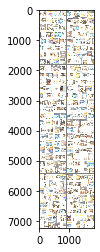

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

classes = train_dataset.classes

# 학습용 이미지를 무작위로 가져오기
dataiter = iter(train_loader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels : 0


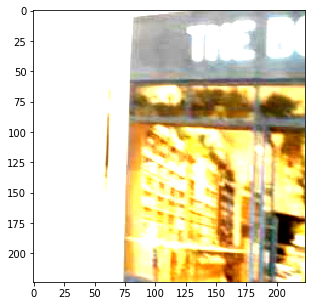

In [5]:
batch = train_dataset.__getitem__(150)
images, labels = batch
grid = torchvision.utils.make_grid(images, 
                                  #nrow = 10
                                  )

plt.figure(figsize = (5,5))
plt.imshow(np.transpose(grid, (1,2,0)))

print('labels :', labels)

In [6]:
train_dataset.classes

['10_THEBODYSHOP',
 '11_BROOKSBROTHERS',
 '12_ZARA',
 '13_VANHART',
 '14_STARFIELD',
 '15_LACOSTE',
 '16_HOLLYS',
 '17_CONVERSE',
 '18_FENDI',
 '19_HERMES',
 '1_STARBUCKS',
 '20_H_M',
 '21_ALDO',
 '22_POLO',
 '23_CLUB_MONACO',
 '24_KIZDOM',
 '25_CARTIER',
 '26_CHICOR',
 '27_CUSTOM_MELLOW',
 '28_YANKEE',
 '29_TOMMY',
 '2_VANS',
 '30_GS',
 '3_BUBERRY',
 '4_GUCCI',
 '5_AT_T',
 '6_CHANEL',
 '7_HATSON',
 '8_GUESS',
 '9_VICTORIA']

## 데이터 확인

In [7]:
print("이미지 shape : ",train_dataset.__getitem__(1)[0].shape)
print("train_set 클래스 : ", train_dataset.classes)
print("train_set length : ", train_dataset.__len__())
print("첫번째 인덱스 데이터 불러오기 : \n", train_dataset.__getitem__(0)[0])
print("첫번째 인덱스 라벨 불러오기 : ", train_dataset.__getitem__(0)[1])

이미지 shape :  torch.Size([3, 224, 224])
train_set 클래스 :  ['10_THEBODYSHOP', '11_BROOKSBROTHERS', '12_ZARA', '13_VANHART', '14_STARFIELD', '15_LACOSTE', '16_HOLLYS', '17_CONVERSE', '18_FENDI', '19_HERMES', '1_STARBUCKS', '20_H_M', '21_ALDO', '22_POLO', '23_CLUB_MONACO', '24_KIZDOM', '25_CARTIER', '26_CHICOR', '27_CUSTOM_MELLOW', '28_YANKEE', '29_TOMMY', '2_VANS', '30_GS', '3_BUBERRY', '4_GUCCI', '5_AT_T', '6_CHANEL', '7_HATSON', '8_GUESS', '9_VICTORIA']
train_set length :  13025
첫번째 인덱스 데이터 불러오기 : 
 tensor([[[ 2.7837e-01,  2.7837e-01,  2.6727e-01,  ...,  1.4114e+00,
           1.4114e+00,  1.4114e+00],
         [ 2.6727e-01,  2.6727e-01,  2.4505e-01,  ...,  1.3004e+00,
           1.3115e+00,  1.3115e+00],
         [ 3.0059e-01,  2.8948e-01,  2.6727e-01,  ...,  1.0671e+00,
           1.0893e+00,  1.1004e+00],
         ...,
         [ 6.6717e-01,  5.8941e-01,  4.8944e-01,  ..., -3.2663e-02,
          -6.5988e-02, -9.9314e-02],
         [ 7.3382e-01,  6.5606e-01,  5.5609e-01,  ...,  6.6261e

## Train / Test set 라벨 전체 저장

In [8]:
# train labels
label_train = []

for i in range(len(train_dataset)):
    train_dataset.train_label = train_dataset.__getitem__(i)[1]
    label_train.append(train_dataset.train_label)

# 텐서로 저장
train_dataset.train_labels = torch.Tensor(label_train)

In [9]:
train_dataset.train_labels

tensor([ 0.,  0.,  0.,  ..., 29., 29., 29.])

In [10]:
# test labels
label_test = []

for i in range(len(test_dataset)):
    test_dataset.test_label = test_dataset.__getitem__(i)[1]
    label_test.append(test_dataset.test_label)
# 텐서 형태로 저장
test_dataset.test_labels = torch.Tensor(label_test)

In [11]:
test_dataset.test_labels

tensor([ 0.,  0.,  0.,  ..., 29., 29., 29.])

## Common setup

In [13]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

fashion_mnist_classes = ['10_THEBODYSHOP',
 '11_BROOKSBROTHERS',
 '12_ZARA',
 '13_VANHART',
 '14_STARFIELD',
 '15_LACOSTE',
 '16_HOLLYS',
 '17_CONVERSE',
 '18_FENDI',
 '19_HERMES',
 '1_STARBUCKS',
 '20_H_M',
 '21_ALDO',
 '22_POLO',
 '23_CLUB_MONACO',
 '24_KIZDOM',
 '25_CARTIER',
 '26_CHICOR',
 '27_CUSTOM_MELLOW',
 '28_YANKEE',
 '29_TOMMY',
 '2_VANS',
 '30_GS',
 '3_BUBERRY',
 '4_GUCCI',
 '5_AT_T',
 '6_CHANEL',
 '7_HATSON',
 '8_GUESS',
 '9_VICTORIA']

# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
#               '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
#               '#bcbd22']

colors = ['#b41f1f','#b44e1f','#b47d1f','#b4a01f','#a3b41f',
         '#82b41f','#5db41f', '#3ab41f','#1fb442','#1fb476',
         '#1fb49e','#1fa0b4','#1f80b4','#1f65b4','#1f47b4',
         '#1f29b4','#3a1fb4', '#5d1fb4','#a31fb4','#b41faa',
         '#b41f8a','#b41f65','#b41f44','#b41f30','#bf8c9c',
         '#8a5816','#638a16', '#318a16','#168a48','#16848a']

mnist_classes = fashion_mnist_classes

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(30):          # 클래스 갯수에 따라서 숫자를 변경해준다.
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes,bbox_to_anchor=(1., 1.))

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 128))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

In [ ]:
'#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd',
         '#8c564b','#e377c2', '#7f7f7f

# Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

## Steps
1. Create a dataset returning triplets - **TripletMNIST** class from *datasets.py*, wrapper for MNIST-like classes
2. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
3. Define **triplet** network processing triplets - **TripletNet** wrapping *EmbeddingNet*
4. Train the network with **TripletLoss** - *losses.py*

In [10]:
# Set up data loaders
from datasets import TripletMNIST

triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 4, 'pin_memory': False} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, TripletNet
from losses import TripletLoss


device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

margin = 1.
embedding_net = EmbeddingNet().to(device)
model = TripletNet(embedding_net)
model = nn.DataParallel(model)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
# lr = 1e-3
lr = 0.0002
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 200
log_interval = 500

AttributeError: 'ImageFolder' object has no attribute 'train_data'

In [11]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

/home/pirl/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train: [0/73 (0%)]	Loss: 0.999645
Epoch: 1/100. Train set: Average loss: 0.9996
Epoch: 1/100. Validation set: Average loss: 237.0717
Train: [0/73 (0%)]	Loss: 354.959930
Epoch: 2/100. Train set: Average loss: 354.9599
Epoch: 2/100. Validation set: Average loss: 10.9211
Train: [0/73 (0%)]	Loss: 25.942656
Epoch: 3/100. Train set: Average loss: 25.9427
Epoch: 3/100. Validation set: Average loss: 1.7327
Train: [0/73 (0%)]	Loss: 1.880137
Epoch: 4/100. Train set: Average loss: 1.8801
Epoch: 4/100. Validation set: Average loss: 4.7884
Train: [0/73 (0%)]	Loss: 5.054254
Epoch: 5/100. Train set: Average loss: 5.0543
Epoch: 5/100. Validation set: Average loss: 6.5126
Train: [0/73 (0%)]	Loss: 11.924223
Epoch: 6/100. Train set: Average loss: 11.9242
Epoch: 6/100. Validation set: Average loss: 4.1319
Train: [0/73 (0%)]	Loss: 5.131078
Epoch: 7/100. Train set: Average loss: 5.1311
Epoch: 7/100. Validation set: Average loss: 19.7269
Train: [0/73 (0%)]	Loss: 19.418417
Epoch: 8/100. Train set: Average los

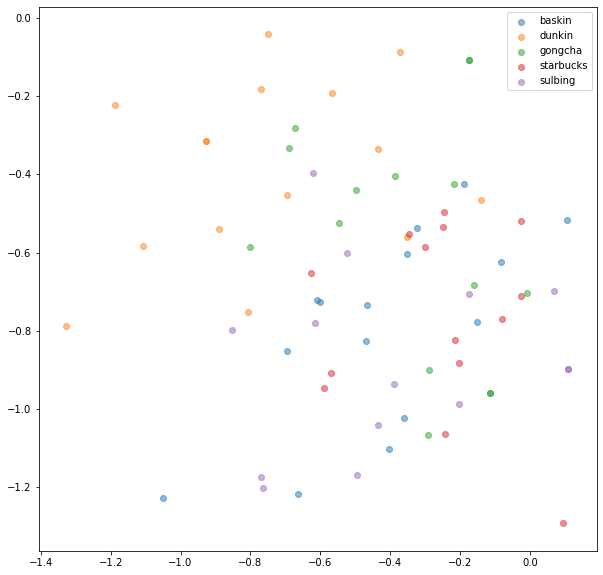

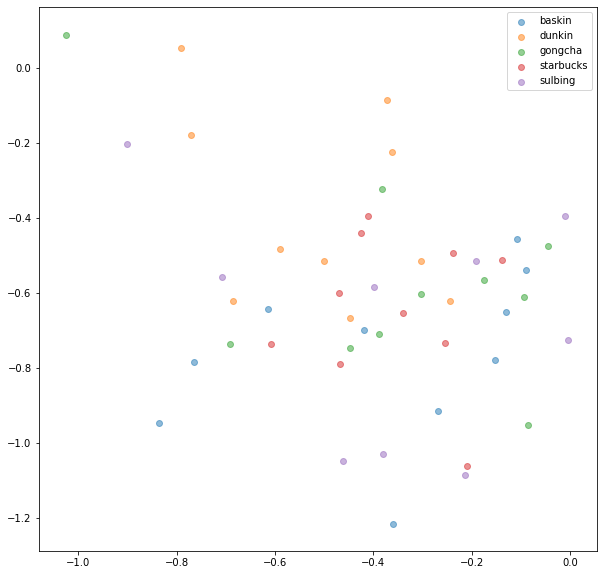

In [12]:
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)

## Online triplet selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **TripletSelector** that takes embeddings and original labels and returns valid triplets within a minibatch
5. Define **OnlineTripletLoss** that will use a *TripletSelector* and compute *TripletLoss* on such pairs
6. Train the network!

In [14]:
import torch.nn as nn
import torchvision.models as models
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=30, n_samples=16)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=30, n_samples=16)

kwargs = {'num_workers': 4, 'pin_memory': True} if cuda else {}
online_train_loader = data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet128
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric

margin = 1.

###
# embedding_net = EmbeddingNet().to(device)
# model = TripletNet(embedding_net)
# model = nn.DataParallel(model)


device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
#net = models.resnet18() 
embedding_net = EmbeddingNet128().to(device)
model = embedding_net
# model = nn.DataParallel(embedding_net)
if cuda:
    model.cuda()

loss_fn = OnlineTripletLoss(margin, SemihardNegativeTripletSelector(margin)) # RandomNegativeTripletSelector
lr = 2e-4
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5) # weight_decay=1e-4
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 150 # 150

## online_train_loader

In [ ]:
# n_classes=9, n_samples=16 weight_decay=1e-3, n_epochs = 20 log_interval = 150
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])

/home/pirl/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train: [0/13025 (0%)]	Loss: 0.500862	Average nonzero triplets: 1034.0
Epoch: 1/20. Train set: Average loss: 0.0242	Average nonzero triplets: 59.22222222222222
Epoch: 1/20. Validation set: Average loss: 0.0495	Average nonzero triplets: 31.3
Train: [0/13025 (0%)]	Loss: 0.449547	Average nonzero triplets: 2.0
Epoch: 2/20. Train set: Average loss: 0.0189	Average nonzero triplets: 3.3703703703703702
Epoch: 2/20. Validation set: Average loss: 0.0493	Average nonzero triplets: 40.4
Train: [0/13025 (0%)]	Loss: 0.348557	Average nonzero triplets: 2.0
Epoch: 3/20. Train set: Average loss: 0.0026	Average nonzero triplets: 2.7777777777777777
Epoch: 3/20. Validation set: Average loss: 0.0501	Average nonzero triplets: 26.5
Train: [0/13025 (0%)]	Loss: 0.420067	Average nonzero triplets: 4.0
Epoch: 4/20. Train set: Average loss: 0.0127	Average nonzero triplets: 2.2962962962962963
Epoch: 4/20. Validation set: Average loss: 0.0510	Average nonzero triplets: 28.9
Train: [0/13025 (0%)]	Loss: 0.301636	Average n

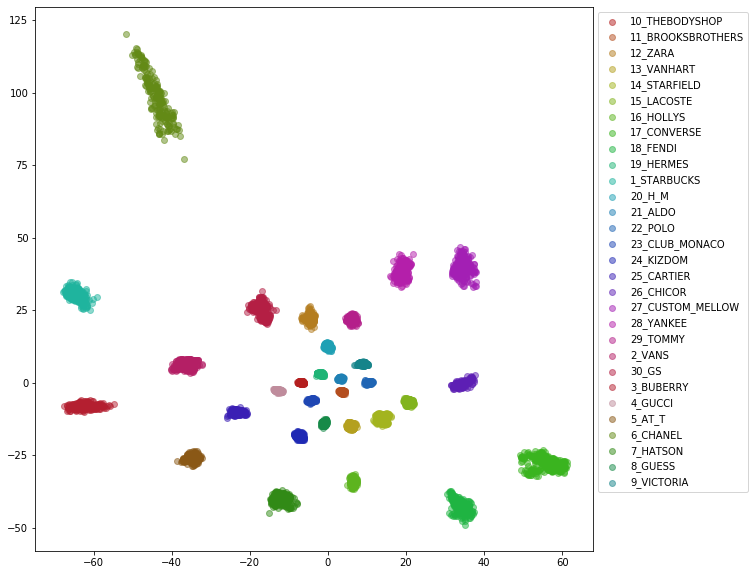

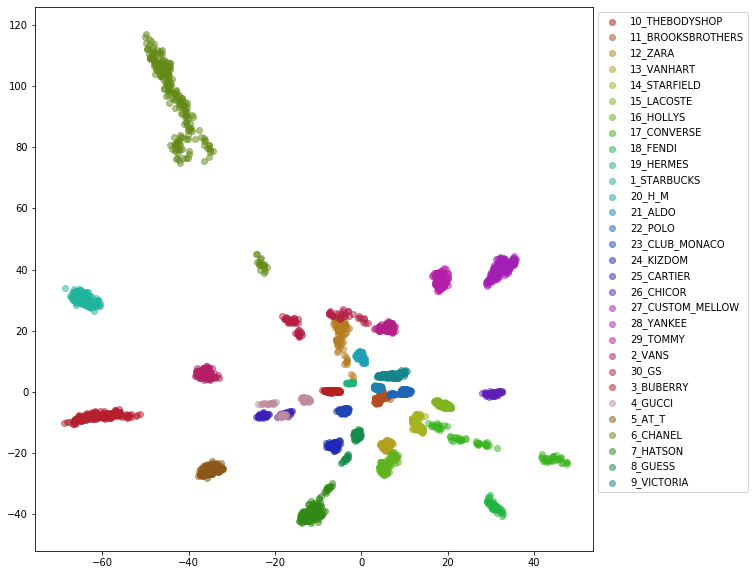

In [32]:
# n_classes=30, n_samples=16 weight_decay=1e-5, lr=2e-4, n_epochs = 20 log_interval = 150
train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl)
val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl)

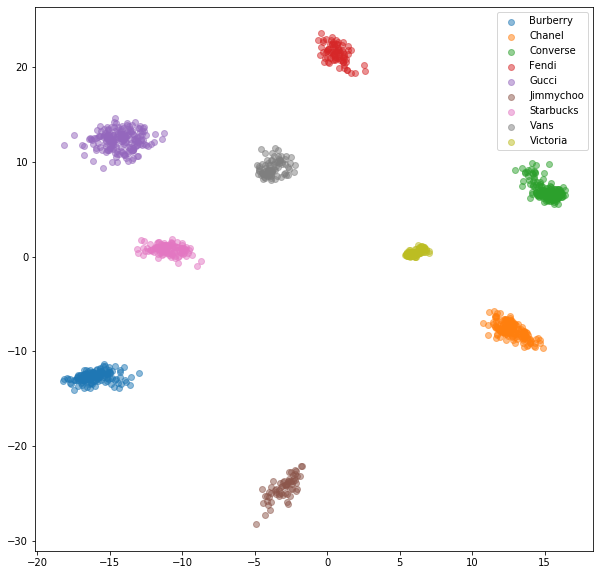

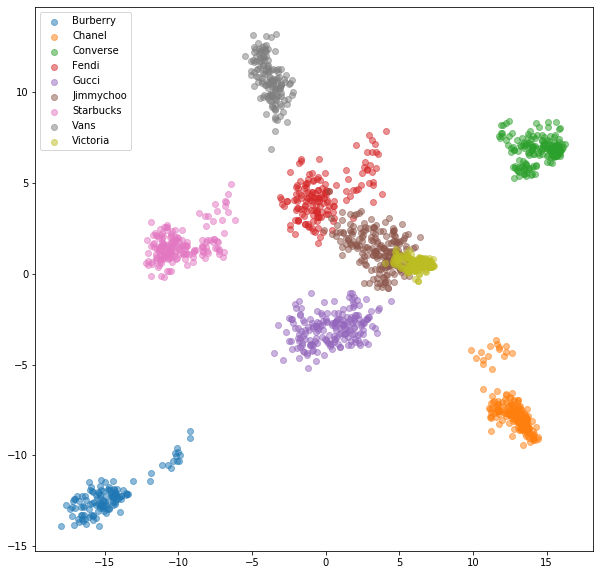

In [13]:
# n_classes=9, n_samples=16 weight_decay=1e-5, lr=2e-4, n_epochs = 20 log_interval = 150
train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl)
val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl)

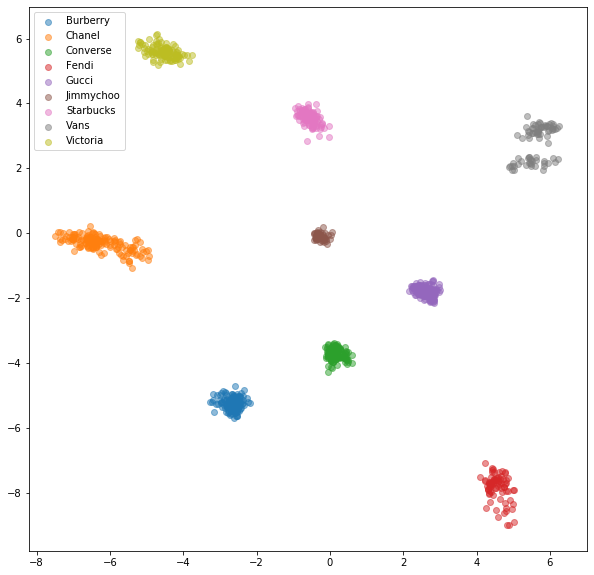

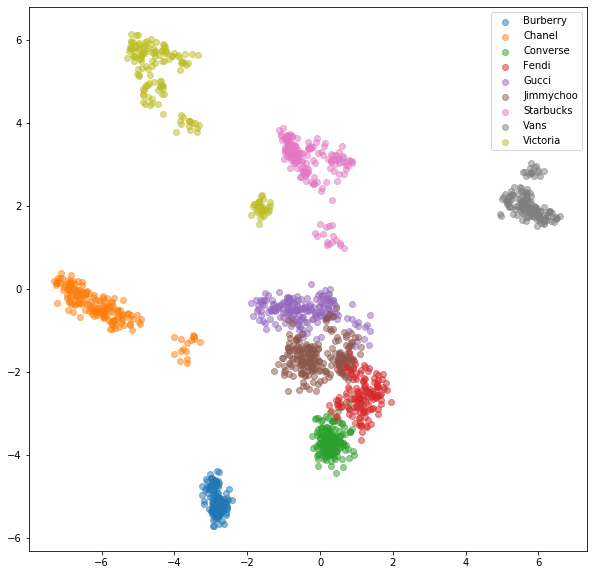

In [9]:
# batch_size = 256, n_samples = 16, epoch = 20 weight_decay=1e-3, lr = 0.001
train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl)
val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl)

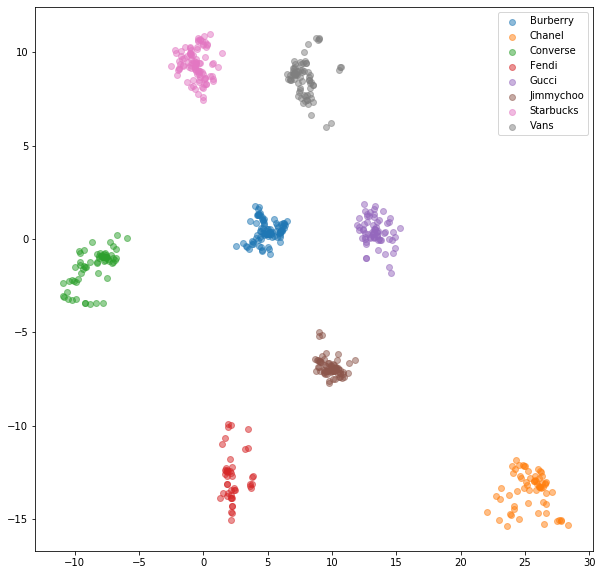

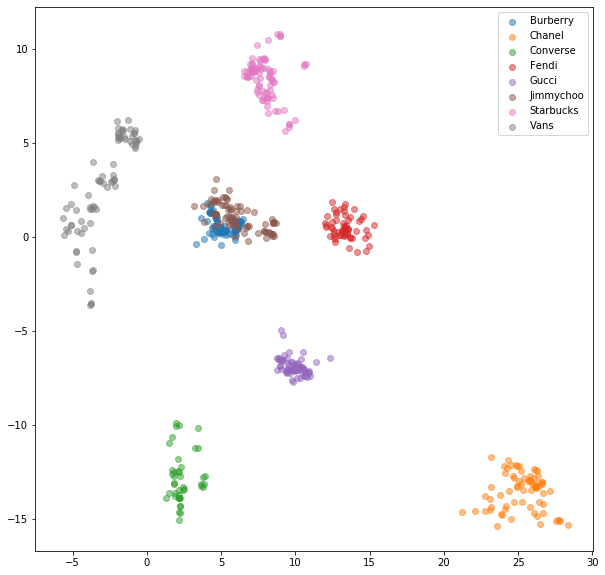

In [17]:
train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl)
val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl)

In [1]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(77, 78)
show_pair(77, 50)

NameError: name 'plt' is not defined

# 이 밑으로는 evaluate 계산해보려고 헛짓거리 한건데 혹시 몰라 남겨는 둘게 ^_<

In [ ]:
from eval_metrics import evaluate

In [1]:
import tqdm

In [16]:
a = enumerate(train_loader)

In [ ]:
for batch_idx, (data_a, data_p, label) in a:
    if aargs.cuda:
        

In [1]:
import operator

In [3]:
import numpy as np

np.arange(0, 30, 0.01)

array([0.000e+00, 1.000e-02, 2.000e-02, ..., 2.997e+01, 2.998e+01,
       2.999e+01])

In [5]:
from scipy import interpolate

In [42]:
img_dir_val = '/home/pirl/Downloads/Project/iimage/'
val_dataset = dset.ImageFolder(img_dir_val, transform = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))]))

val_loader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [43]:
img_dir_va = '/home/pirl/Downloads/Project/iimagee/'
va_dataset = dset.ImageFolder(img_dir_va, transform = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))]))

va_loader = data.DataLoader(va_dataset, batch_size=batch_size, shuffle=False, **kwargs)

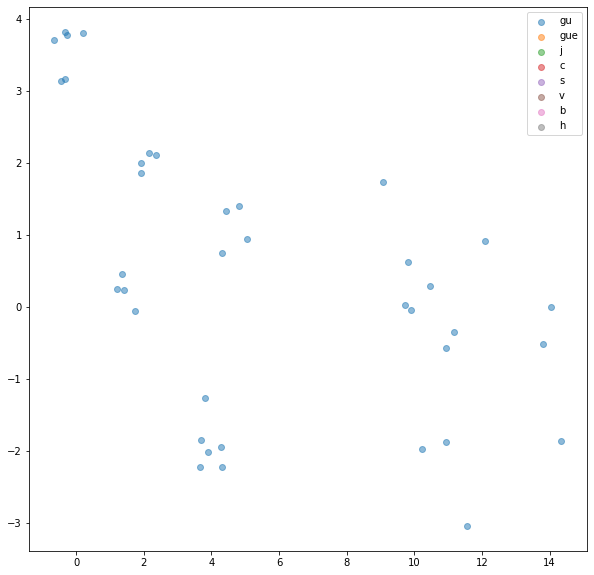

In [44]:
val_embeddings_otl, val_labels_otl = extract_embeddings(val_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl)
# val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
# plot_embeddings(val_embeddings_otl, val_labels_otl)

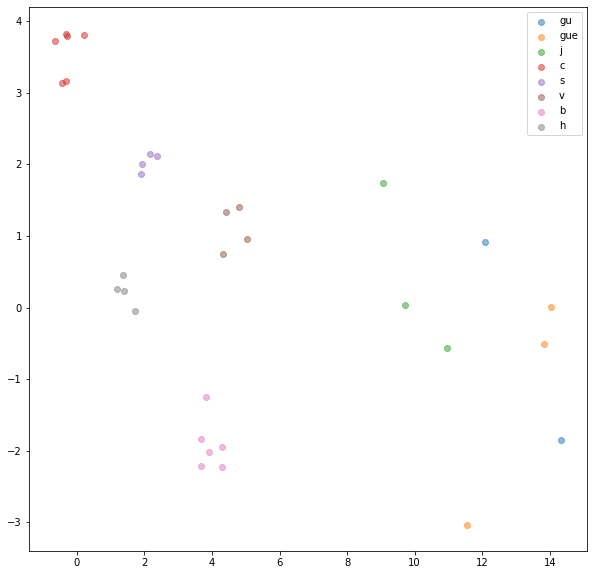

In [45]:
va_embeddings_otl, va_labels_otl = extract_embeddings(va_loader, model)
plot_embeddings(va_embeddings_otl, va_labels_otl)
# val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
# plot_embeddings(val_embeddings_otl, val_labels_otl)

In [ ]:
conda update -n base -c defaults conda# display_emb_online, display_emb, display_label_online, display_label = train_embeddings_otl, train_embeddings_tl, train_labels_otl, train_labels_tl
# display_emb_online, display_emb, display_label_online, display_label = val_embeddings_ocl, val_embeddings_cl, val_labels_ocl, val_labels_cl
display_emb_online, display_label_online = train_embeddings_otl,  train_labels_otl


x_lim = (np.min(display_emb_online[:,0]), np.max(display_emb_online[:,0]))
y_lim = (np.min(display_emb_online[:,1]), np.max(display_emb_online[:,1]))
# x_lim = (min(x_lim[0], np.min(display_emb[:,0])), max(x_lim[1], np.max(display_emb[:,0])))
# y_lim = (min(y_lim[0], np.min(display_emb[:,1])), max(y_lim[1], np.max(display_emb[:,1])))

# plot_embeddings(display_emb, display_label, x_lim, y_lim)
plot_embeddings(display_emb_online, display_label_online, x_lim, y_lim)

In [ ]:
display_emb_online, display_label_online = train_embeddings_otl, train_labels_otl
# display_emb_online, display_emb, display_label_online, display_label = val_embeddings_otl, val_embeddings_tl, val_labels_otl, val_labels_tl
x_lim = (np.min(display_emb_online[:,0]), np.max(display_emb_online[:,0]))
y_lim = (np.min(display_emb_online[:,1]), np.max(display_emb_online[:,1]))
# x_lim = (min(x_lim[0], np.min(display_emb[:,0])), max(x_lim[1], np.max(display_emb[:,0])))
# y_lim = (min(y_lim[0], np.min(display_emb[:,1])), max(y_lim[1], np.max(display_emb[:,1])))
# plot_embeddings(display_emb, display_label, x_lim, y_lim)
plot_embeddings(display_emb_online, display_label_online, x_lim, y_lim)

In [ ]:
display_emb_online

In [ ]:
display_label_online

In [ ]:
extract_embeddings(train_loader, model)

In [ ]:
next(iter(train_loader))

In [ ]:
iter(train_loader)

In [ ]:
import torchvision

batch = next(iter(train_loader))
images, labels = batch
grid = torchvision.utils.make_grid(images, 
                                  # nrow = 10
                                  )

plt.figure(figsize = (30,30))
plt.imshow(np.transpose(grid, (1,2,0)))

print('labels :', labels)

In [ ]:
import torchvision

batch = next(iter(train_loader))
images, labels = batch
grid = torchvision.utils.make_grid(images[0], 
                                  # nrow = 10
                                  )

plt.figure(figsize = (10,10))
plt.imshow(np.transpose(grid, (1,2,0)))

print('labels :', labels[0])

In [ ]:
import torchvision

batch = next(iter(train_loader))
images, labels = batch
for i in range(len(images)):
    grid = torchvision.utils.make_grid(images[i], 
                                  # nrow = 10
                                  )
    print('labels :', labels[i])
    plt.imshow(np.transpose(grid,(1,2,0).type(np.uint8)))
#     plt.imshow(np.transpose(grid, (1,2,0)))

plt.figure(figsize = (5,5))
# plt.imshow(np.transpose(grid, (1,2,0)))

# print('labels :', labels)

In [ ]:
import torchvision

batch = next(iter(extract_embeddings(train_loader, model)))
images, labels = batch
grid = torchvision.utils.make_grid(images, 
                                  # nrow = 10
                                  )

plt.figure(figsize = (20,20))
plt.imshow(np.transpose(grid, (1,2,0)))

print('labels :', labels)